In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
print("Avaliable Activation Functions:")
print("1) h(α) = log(1 + e^α)")
print("2) h(α) = tanh(α)")
print("3) h(α) = cos(α)")
select = input("Select one activation function from 1 to 3: ")
select = int(select)
if(select!=1 and select!=2 and select!=3):
    print('You select an incorrect function. Please try again!')
else:
    print("You choose function: "+str(select))

Avaliable Activation Functions:
1) h(α) = log(1 + e^α)
2) h(α) = tanh(α)
3) h(α) = cos(α)
Select one activation function from 1 to 3: 3
You choose function: 3


### Activation Functions

In [60]:
def activation_functions(select, Z_init):

    if select == 1:
        Z = np.log(1+np.exp(Z_init))

    elif select == 2:
        Z = np.tanh(Z_init) 
    
    elif select == 3:
        Z = np.cos(np.deg2rad(Z_init))
        
    return Z

### Activation Functions Derivatives

In [61]:
def activation_derivatives(select, Z_init):
    
    if select == 1:
        H = (np.exp(Z_init))/(1+np.exp(Z_init))
    
    elif select == 2:
        H = (1 - (np.tanh(Z_init))**2) 
    
    elif select == 3:
        H = (-np.sin(Z_init)) 
  
    return H

### Softmax

In [5]:
#use by default ax=1, when the array is 2D
#use ax=0 when the array is 1D
def softmax( x, ax=1 ):
    m = np.max( x, axis=ax, keepdims=True )#max per row
    p = np.exp( x - m )
    return ( p / np.sum(p,axis=ax,keepdims=True) )

### Mnist Dataset
In the data folder there is the dataset of mnist. Mnists consists of $28x28$ grayscale images. In total there are 10 training files
train0.txt, train1.txt, ..., train9.txt where each rows of train$k$.txt corresponds to an example that belongs to the class $k$.

The testing data follows the same format.

In total we have $6*10^4$ training examples and $10^3$ testing examples

In [6]:
def load_data():
    """
    Load the MNIST dataset. Reads the training and testing files and create matrices.
    :Expected return:
    train_data:the matrix with the training data
    test_data: the matrix with the data that will be used for testing
    y_train: the matrix consisting of one 
                        hot vectors on each row(ground truth for training)
    y_test: the matrix consisting of one
                        hot vectors on each row(ground truth for testing)
    """
    
    #load the train files
    df = None
    
    y_train = []

    for i in range( 10 ):
        tmp = pd.read_csv( 'data/mnist/train%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
        
        for j in range( tmp.shape[0] ):
            y_train.append( hot_vector )
        #concatenate dataframes by rows    
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    train_data = df.as_matrix()
    y_train = np.array( y_train )
    
    #load test files
    df = None
    
    y_test = []

    for i in range( 10 ):
        tmp = pd.read_csv( 'data/mnist/test%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]
        
        for j in range( tmp.shape[0] ):
            y_test.append( hot_vector )
        #concatenate dataframes by rows    
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    test_data = df.as_matrix()
    y_test = np.array( y_test )
    
    return train_data, test_data, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = load_data() #load data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

C:\Users\GiannisF\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(60000, 784) (10000, 784) (60000, 10) (10000, 10)


C:\Users\GiannisF\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### View of the dataset

C:\Users\GiannisF\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


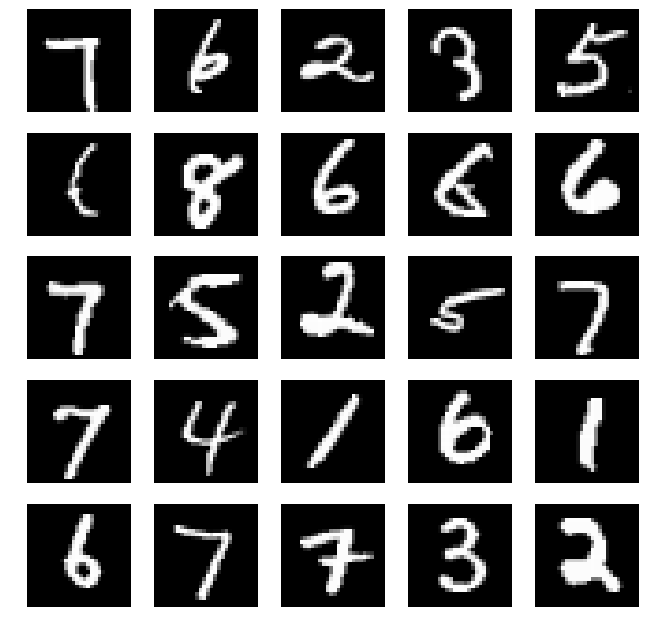

In [8]:
# plot 5 random images from the training set
n = 25
sqrt_n = int( n**0.5 )
samples = np.random.randint(X_train.shape[0], size=n)

plt.figure( figsize=(11,11) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_train[i].reshape(28,28), cmap='gray')

plt.show()

### Normalize the dataset

In [9]:
X_train = X_train.astype(float)/255
X_test = X_test.astype(float)/255

Add column of ones to the dataset

In [10]:
X_train = np.hstack( (np.ones((X_train.shape[0],1) ), X_train) )
X_test = np.hstack( (np.ones((X_test.shape[0],1) ), X_test) )

In [11]:
X_train.shape

(60000, 785)

For the cost function

$$
E(W) = \sum_{n=1}^N \left[ \left( \sum_{k=1}^K t_{nk} \mathbf{w_{(2)}}_k^T \mathbf{z}_n \right) - \log \left( \sum_{j=1}^K e^{\mathbf{w_{(2)}}_j^T \mathbf{z}_n} \right) \right]   -  \frac{\lambda}{2} \sum_{k=1}^K ||\mathbf{w}||^2, 
$$


we use the logsumexp trick, where m is the maximum element
\begin{align} 
\log \sum_{i=1}^{n} e^{\mathbf{w_{(2)}}_j^T \mathbf{z}_n} &= \log \Bigr( \sum_{i=1}^{n} e^{\mathbf{w_{(2)}}_j^T \mathbf{z}_n +m -m}\Bigl) \\ 
&= \log \Bigr( \sum_{i=1}^{n} e^m e^{\mathbf{w_{(2)}}_j^T \mathbf{z}_n-m} ) \Bigl) \\ 
&= \log \Bigr( e^m \sum_{i=1}^{n} e^{\mathbf{w_{(2)}}_j^T \mathbf{z}_n-m} ) \Bigl) \\ 
&= \log \ e^m + \log \Bigr( \sum_{i=1}^{n} e^{\mathbf{w_{(2)}}_j^T \mathbf{z}_n-m} ) \Bigl) \\ 
&= m + \log \Bigr( \sum_{i=1} e^{\mathbf{w_{(2)}}_j^T \mathbf{z}_n-m}  \Bigl) 
\end{align}

For w2 derivatives we use: $$
(T - S)^Τ Z - \lambda W_{(2)}
$$

and for W1 derivatives: $$
((T - Y)W_{(2)}H')^Τ X - \lambda W_{(1)}
$$

In [12]:
def cost_grad_softmax(W1, W2, X, Z, t, lamda):
    
    y = Z.dot(W2.T)
    max_error = np.max(y, axis=1)
    
    s = softmax(y)
    
    # Compute the cost function to check convergence
    # Using the logsumexp trick for numerical stability - lec8.pdf slide 43
    Ew = np.sum(t * y) - np.sum(max_error) - \
        np.sum(np.log(np.sum(np.exp(y - np.array([max_error, ] * y.shape[1]).T), 1))) - \
        (0.5 * lamda) * (np.sum(np.square(W2))) 

    # calculate gradient
    gradEw2 = (t - s).T.dot(Z) - lamda * W2
    gradEw1 = (((np.multiply((t - s).dot(W2), (activation_derivatives(select, Z)))).T).dot(X))[1:,:] - lamda * W1
        
    return Ew, gradEw1, gradEw2

In [13]:
def ml_softmax_train(t, X, lamda, W1_init, W2_init, options):
    """inputs :
      t: N x K binary output data vector indicating the k classes
      X: N x (D+1) input data vector with ones already added in the first column
      lamda: the positive regularizarion parameter
      W1_init: M x (D+1) dimensional vector of the initial values of the parameters for W1
      W2_init: K x (M+1) dimensional vector of the initial values of the parameters for W2
      options: options(1) is the maximum number of iterations
               options(2) is the tolerance
               options(3) is the learning rate eta
    outputs :
      w1: the trained M x (D+1) dimensional vector of the parameters
      w2: the trained K x (M+1) dimensional vector of the parameters"""
        
    
    W1 = W1_init
    W2 = W2_init
    

    # Maximum number of iteration of gradient ascend
    _iter = options[0]
    # Tolerance
    tol = options[1]
    # Learning rate
    eta = options[2]

    Ewold = -np.inf
    costs = []

    Z = np.zeros((X.shape[0],W1.shape[0]))
    Z = np.hstack( (np.ones((Z.shape[0],1) ), Z) )
        
    
    for i in range( 1, _iter+1 ):
        
        Z[:,1:] = activation_functions(select, X.dot(W1.T))    

        
        Ew, gradEw1, gradEw2 = cost_grad_softmax(W1, W2, X, Z, t, lamda)
        
        # save cost
        costs.append(Ew)
        # Show the current cost function on screen
        if i % 50 == 0:
            print('Iteration : %d, Cost function :%f' % (i, Ew))
            
        # Break if you achieve the desired accuracy in the cost function
        if np.abs(Ew - Ewold) < tol:
            break
                        
        # Update parameters based on gradient ascend
        W1 = W1 + eta * gradEw1
        W2 = W2 + eta * gradEw2
        
        Ewold = Ew
    
    return W1, W2, costs

### Gradient checking

lec4_b.pdf - Slide 20


During gradient ascent/descent we compute the gradients $\frac{\partial E}{\partial w}$, where $w$ denotes the parameters of the model.

In order to make sure that these gradients are correct we will compare the exact gradients(that we have coded) with numerical estimates obtained by finite differences, you can use your code for computing $E$ to verify the code for computing $\frac{\partial E}{\partial w}$.
    Let's look back at the definition of a derivative (or gradient):
    
$$ \frac{\partial E}{\partial w} = \lim_{\varepsilon \to 0} \frac{E(w + \varepsilon) - E(w - \varepsilon)}{2 \varepsilon} \tag{1}$$  

We know the following: 
- $\frac{\partial E}{\partial w}$ is what you want to make sure you're computing correctly. ,
- You can compute $E(w + \varepsilon)$ and $E(w - \varepsilon)$ (in the case that $w$ is a real number), since you're confident your implementation for $E$ is correct.

Let's use equation (1) and a small value ( around $10^-4$ or $10^-6$, much smaller values could lead to numerical issues )for $\varepsilon$ to make sure that your code for computing  $\frac{\partial E}{\partial w}$ is correct!

In [14]:
def gradcheck_softmax(W1, W2, X, t, lamda):
    
    W1 = np.random.rand(*W1.shape)
    W2 = np.random.rand(*W2.shape)
    epsilon = 1e-6
    
    _list = np.random.randint(X.shape[0], size=5)
    x_sample = np.array(X[_list, :])
    t_sample = np.array(t[_list, :])
    
    Z = np.zeros((X.shape[0],W1.shape[0]))
    Z = np.hstack( (np.ones((Z.shape[0],1) ), Z) )
    Z[:,1:] = activation_functions(select, X.dot(W1.T))
    z_sample= np.array(Z[_list, :])
    
    Ew, gradEw1, gradEw2 = cost_grad_softmax(W1, W2, x_sample, z_sample, t_sample, lamda)
    #Ew, gradEw = cost_grad_softmax(W, x_sample, x_sample, lamda)
    
    print( "gradEw1 shape: ", gradEw1.shape )
    print( "gradEw2 shape: ", gradEw2.shape )
    
    numericalGrad1 = np.zeros(gradEw1.shape)
    numericalGrad2 = np.zeros(gradEw2.shape)
    # Compute all numerical gradient estimates and store them in
    # the matrix numericalGrad
    for k in range(numericalGrad1.shape[0]):
        for d in range(numericalGrad1.shape[1]):
            
            #add epsilon to the w1[k,d]
            w_tmp = np.copy(W1)
            w_tmp[k, d] += epsilon
            e_plus, _, _= cost_grad_softmax(w_tmp,W2, x_sample,z_sample, t_sample, lamda)

            #subtract epsilon to the w1[k,d]
            w_tmp = np.copy(W1)
            w_tmp[k, d] -= epsilon
            e_minus, _, _= cost_grad_softmax(w_tmp,W2, x_sample,z_sample, t_sample, lamda)
            
            #approximate gradient ( E[ w1[k,d] + theta ] - E[ w1[k,d] - theta ] ) / 2*e
            numericalGrad1[k, d] = (e_plus - e_minus) / (2 * epsilon)
            
    for k in range(numericalGrad2.shape[0]):
        for d in range(numericalGrad2.shape[1]):
            
            #add epsilon to the w2[k,d]
            w_tmp = np.copy(W2)
            w_tmp[k, d] += epsilon
            e_plus, _, _= cost_grad_softmax(W1,w_tmp, x_sample,z_sample, t_sample, lamda)

            #subtract epsilon to the w2[k,d]
            w_tmp = np.copy(W2)
            w_tmp[k, d] -= epsilon
            e_minus, _, _= cost_grad_softmax(W1,w_tmp, x_sample,z_sample, t_sample, lamda)
            
            #approximate gradient ( E[ w2[k,d] + theta ] - E[ w2[k,d] - theta ] ) / 2*e
            numericalGrad2[k, d] = (e_plus - e_minus) / (2 * epsilon)
    
    return  gradEw1, gradEw2, numericalGrad1, numericalGrad2 

### Training

In [67]:
# N of X
N, D = X_train.shape

# value of hidden units M
#M = 100
#M = 200
M = 300

K = 10

# initialize w1 and w2 for the gradient ascent
W1_init = 2 * np.random.random((M,D)) - 1
W2_init = 2 * np.random.random((K,M+1)) - 1

# regularization parameter
lamda = 0.01

# options for gradient descent
options = [300, 1e-6, 0.08/N]

'''
gradEw1, gradEw2, numericalGrad1, numericalGrad2 = gradcheck_softmax(W1_init, W2_init, X_train, y_train, lamda)

# Absolute norm
print( "The difference estimate for gradient of w1 is : ", np.max(np.abs(gradEw1 - numericalGrad1)) )
print( "The difference estimate for gradient of w2 is : ", np.max(np.abs(gradEw2 - numericalGrad2)) )
'''

# Train the model
W1, W2, costs = ml_softmax_train(y_train, X_train, lamda, W1_init, W2_init, options)

Iteration : 50, Cost function :-150234.207027
Iteration : 100, Cost function :-141176.805908
Iteration : 150, Cost function :-130706.513441
Iteration : 200, Cost function :-118323.388371
Iteration : 250, Cost function :-108807.307457
Iteration : 300, Cost function :-98023.233391


### Cost plot

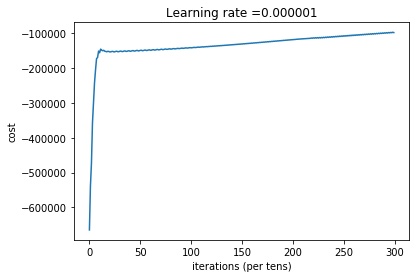

In [68]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(format(options[2], 'f')))
plt.show()

### Predict

In [69]:
def ml_softmax_test(W1, W2, X_test):
    ytest = softmax( activation_functions(select, X_test.dot(W1.T)).dot((W2[:,1:]).T))
    # Hard classification decisions
    ttest = np.argmax(ytest, 1)
    return ttest

In [70]:
pred = ml_softmax_test(W1, W2, X_test)

### Accuracy

In [71]:
np.mean( pred == np.argmax(y_test,1) )

0.344

Now lets take a look at our test data. Check out some of the misclassified test data.

C:\Users\GiannisF\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


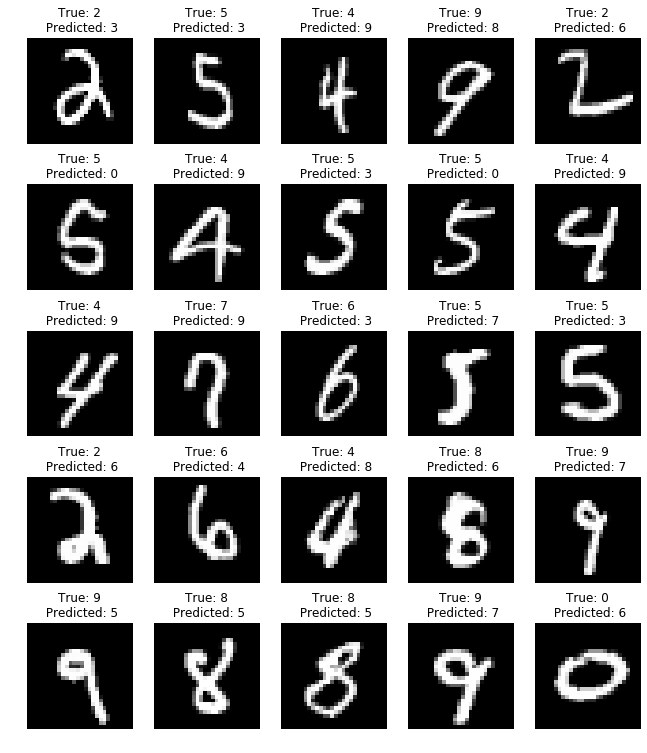

In [34]:
faults = np.where(np.not_equal(np.argmax(y_test,1),pred))[0]
# plot n misclassified examples from the Test set
n = 25
samples = np.random.choice(faults, n)
sqrt_n = int( n ** 0.5 )
plt.figure( figsize=(11,13) )

cnt = 0
for i in samples:
    cnt += 1
    plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_test[i,1:].reshape(28,28)*255, cmap='gray' )
    plt.title("True: "+str(np.argmax(y_test,1)[i])+ "\n Predicted: "+ str(pred[i]))
    
plt.show()